## Assess the relationship between (c1, c2), motion and shear in K25

TODO: Fit plot with weigthed contribution with a sinus. Maybe I should define the weigthed contribution otherwise, like adding 90° to the wind shear?

En fait, on a quasiment c1 = motion et c2 = shear; ce qui explique que le maximum soit localisé en arctan(c1 / c2). Etre très clair là dessus. Revenir dessus en fin de papier. 

Rq: Asymmetry increases with storm motion (shear explains a little bit the spread), but TCs tend to be more axisymmetric during intensification. Storm motion slightly decreases overall across the TC life cycle (in the SAR database), but almost not significant. That supports the imporance of shear and motion for the TC intensification.

I could also do a Ncomm: Physical Understanding of the relationship between motion, shear and asymmetric surface wind field?

Une des recommendations est que les modèles paramétriques de vent asymétrique doivent prendre en compte la weighted contribution (i.e motion + shear)

In [4]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [5]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/05_ASSESS_C1C2_MOTION_SHEAR/',
}

PRMS = {
    'sav_fgs': False,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [6]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 10) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) & 
    (dsg.dist2coast  > dsg.r34)              # Distance to coast
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

472


In [7]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### 0) Fitting diagnostic and datasets filtering

The retained filters are:

In [8]:
# dk01 = dkg01.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
#     (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
#     (dkg01.vmx > 20)                            & # Test
#     (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
#     (dkg01.C_K01 != 0.1)                        &  # Reached the upper bound
#     (dkg01.asym_avg_err  <= 3)                     # Asymmetry is fitted
#     # (~xr.where(dkg01.non_C1 == 0, False, True))  # Ensure that I > V/r
# )

# abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5

With the subtility that dkg01.asym_avg_err <= 3 for K01 and dkg.asym_avg_err  <= 2 for K25 (explainable because the K01 asymmetries are less consistent with SAR than the K25 ones). Also, the non-C1 filter can be a posteriori highlighted on the plots. 

Lastly, we have to include the additional filter: abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5 and same for K25, to make sure that I don't have any fitting issue (where dk01 is with fixed_K = 50 and dk012 is with fixed_K = 100).

#### a) K01_FIT

In [9]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto50.nc'
dkg01 = xr.open_dataset(p)
dk01  = dkg01.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
    (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01.vmx > 20)                            & # Test
    (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01.asym_avg_err  <= 3)                    # Asymmetry is fitted
    # (~xr.where(dkg01.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01.phase_avg_err <= 45)                 &           # Test
    # ((dkg01.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01.time))
print(len(dk01.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
306


In [10]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto100.nc'
dkg01_withKsetto100 = xr.open_dataset(p)
dk01_withKsetto100  = dkg01_withKsetto100.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
    (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto100.vmx > 20)                                          & # Test
    (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto100.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar <2)) # Test
    # (dkg01_withKsetto100.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto100.time))
print(len(dkg01_withKsetto100.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


In [11]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto10.nc'
dkg01_withKsetto10 = xr.open_dataset(p)
dk01_withKsetto10  = dkg01_withKsetto10.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
    (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto10.vmx > 20)                                          & # Test
    (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar <2)) # Test
    # (dkg01_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto10.time))
print(len(dkg01_withKsetto10.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

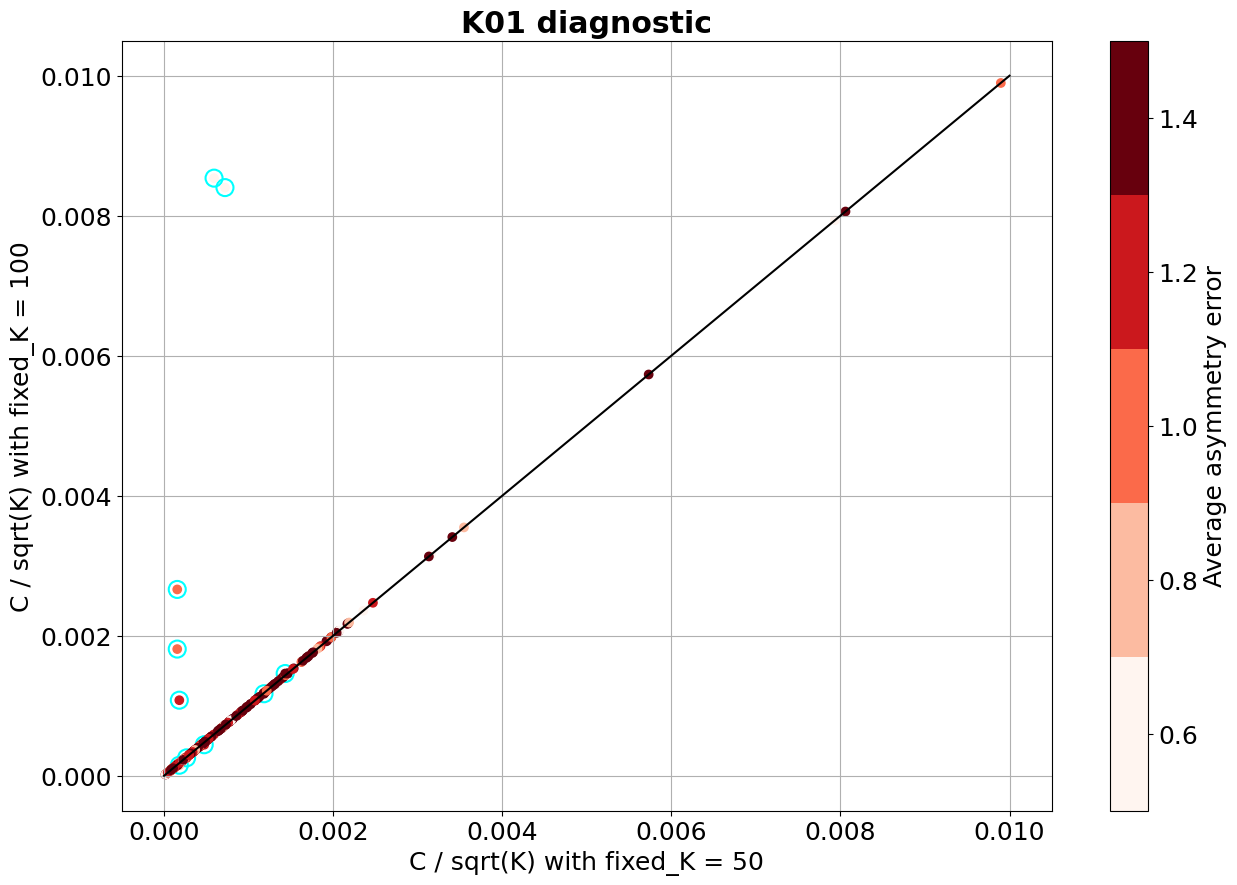

In [12]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_upper = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_upper).C_sqrtK_K01, dk01_withKsetto100.where(msk_k01_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto100.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

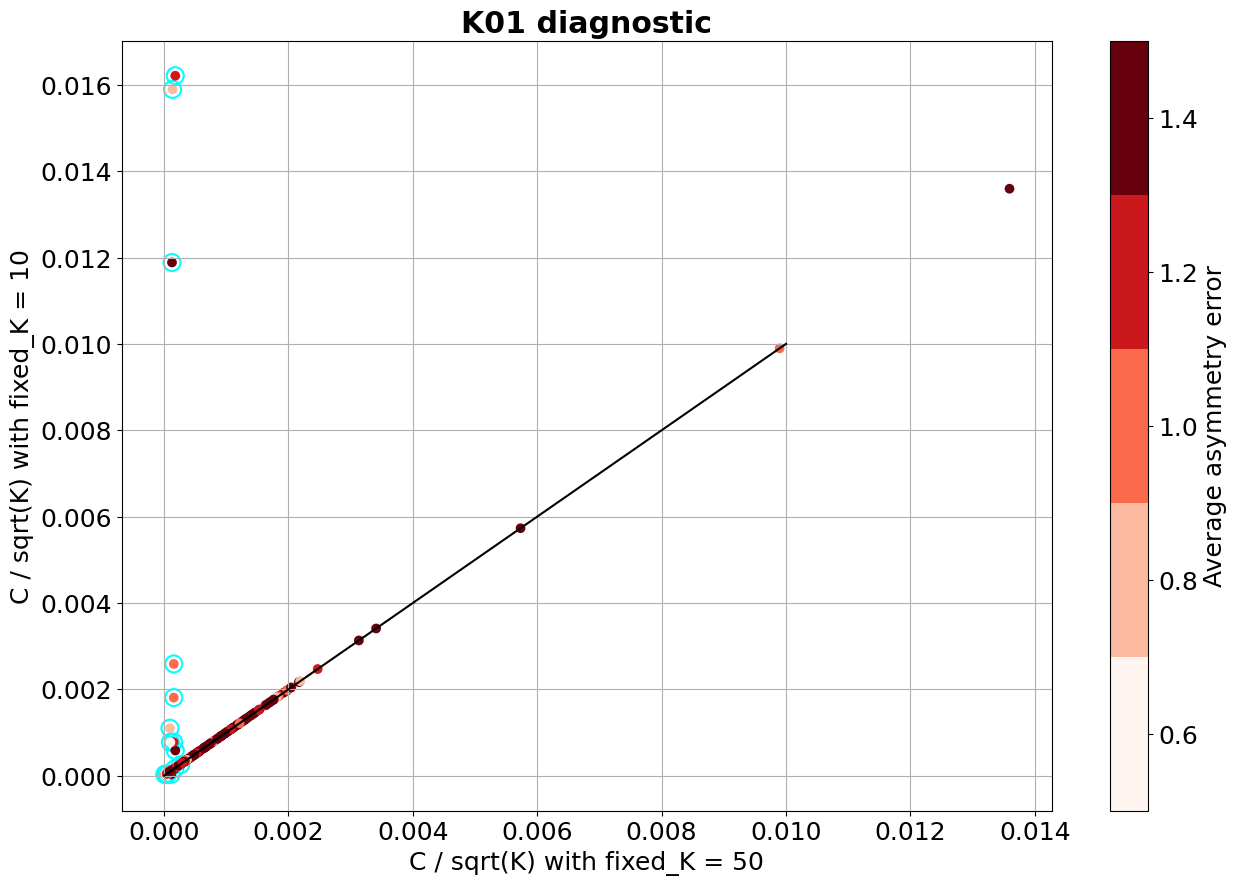

In [13]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_lower = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_lower).C_sqrtK_K01, dk01_withKsetto10.where(msk_k01_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto10.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

For ~30-50 cases, the fitting bounds for C are reached (see commented cell below). They correspond to complicated cases.

In [14]:
# a  = dkg01_withKsetto10.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
#     (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01_withKsetto100.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
#     (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### b) K25_FIT

In [15]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
dkg25 = xr.open_dataset(p)
dk25  = dkg25.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25.dist2coast  > dkg25.r34)             & # Distance to coast
    (dkg25.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25.vmx > 20)                            & # Test
    (dkg25.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25.asym_avg_err  <= 2)                    # Asymmetry is fitted
    # (~xr.where(dkg25.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25.phase_avg_err <= 45)                           & # Test
    # (dkg25.C_sqrtK_K25 > 1.5e-5)                          & # Test: Reached the lower bound
    # (dkg25.C_sqrtK_K25 < 1.41e-3)                         & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25.time))
print(len(dk25.dropna(dim='time', subset=['vmx']).time))

472
362


In [16]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto100.nc'
dkg25_withKsetto100 = xr.open_dataset(p)
dk25_withKsetto100  = dkg25_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
    (dkg25_withKsetto100.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_withKsetto100.vmx > 20)                          & # Test
    (dkg25_withKsetto100.C_K25 != 0.0001)                   & # Reached the lower bound
    (dkg25_withKsetto100.C_K25 != 0.1)                      & # Reached the upper bound
    (dkg25_withKsetto100.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto100.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25_withKsetto100.phase_avg_err <= 45)                                         & # Test
    # (dkg25_withKsetto100.C_sqrtK_K25 > 1.5e-5)                                        & # Test: Reached the lower bound
    # (dkg25_withKsetto100.C_sqrtK_K25 < 1.41e-3)                                       & # Test: Reached the upper bound    
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_withKsetto100.time))
print(len(dk25_withKsetto100.dropna(dim='time', subset=['vmx']).time))

472
373


In [17]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto10.nc'
dkg25_withKsetto10 = xr.open_dataset(p)
dk25_withKsetto10  = dkg25_withKsetto10.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)             & # Distance to coast
    (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg25_withKsetto10.vmx > 20)                                          & # Test
    (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
    (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
    (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg25_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar <2)) # Test
    # (dkg25_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25_withKsetto10.time))
print(len(dkg25_withKsetto10.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

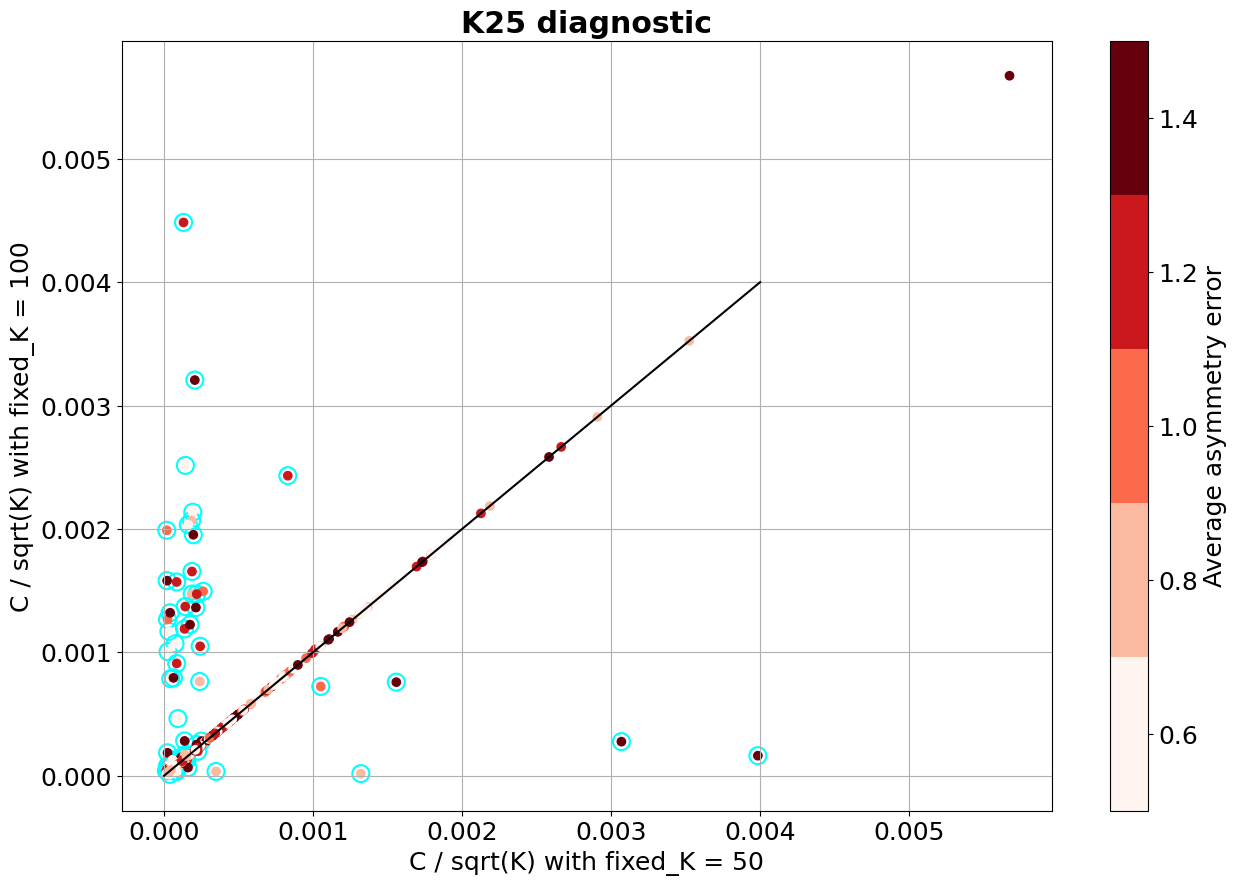

In [18]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_upper = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_upper).C_sqrtK_K25, dk25_withKsetto100.where(msk_k25_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto100.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

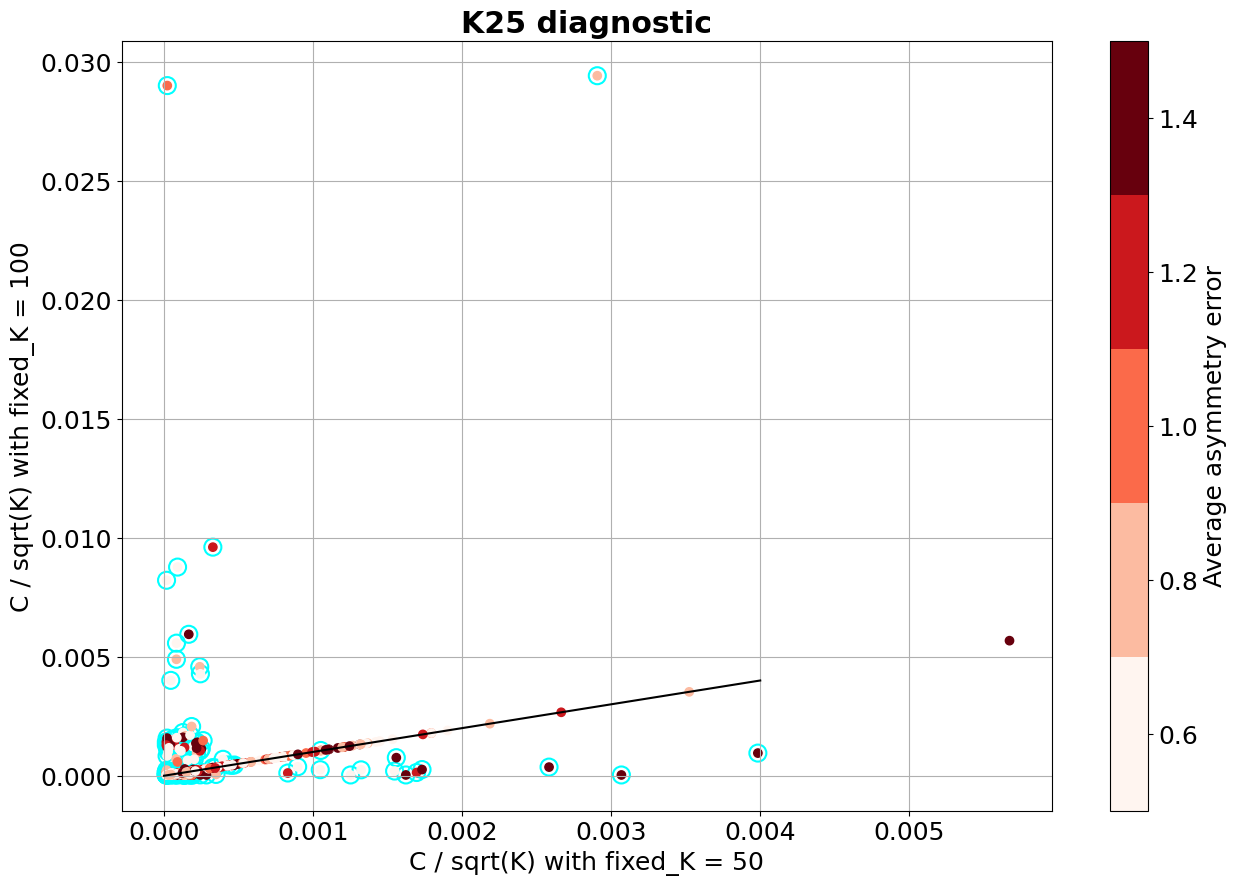

In [19]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_lower = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_lower).C_sqrtK_K25, dk25_withKsetto10.where(msk_k25_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto10.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

The fitting bounds for C are not reached (see commented cell below).

In [20]:
# a  = dkg25_withKsetto10.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)             & # Distance to coast
#     (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25_withKsetto100.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
#     (dkg25_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto100.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto100.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### c) K25_semiFit

In [21]:
### K25 SemiFit
p             = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/dsg_K25_semiFit.nc'
dkg25_semiFit = xr.open_dataset(p)
dk25_semiFit  = dkg25_semiFit.where(
    # (dkg25_semiFit.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_semiFit.dist2coast  > dkg25_semiFit.r34)     & # Distance to coast
    (dkg25_semiFit.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_semiFit.vmx > 20)                          & # Test
    (dkg25_semiFit.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_semiFit.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # (dkg25_semiFit.phase_avg_err <= 45)               & # Test
    # (dkg25_semiFit.C_sqrtK_K25 > 1.5e-5)              & # Test: Reached the lower bound
    # (dkg25_semiFit.C_sqrtK_K25 < 1.41e-3)             & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_semiFit.time))
print(len(dk25_semiFit.dropna(dim='time', subset=['vmx']).time))

472
410


#### d) K01_wIA

In [22]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto50.nc'
dkg01i = xr.open_dataset(p)
dk01i  = dkg01i.where(
    # (dkg01.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg01i.dist2coast  > dkg01i.r34)            & # Distance to coast
    (dkg01i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01i.vmx > 20)                            & # Test
    (dkg01i.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01i.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg01i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg01i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01i.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01i.phase_avg_err <= 45)                 &           # Test
    # ((dkg01i.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i.time))
print(len(dk01i.dropna(dim='time', subset=['vmx']).time))

354
243


In [23]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto100.nc'
dkg01i_withKsetto100 = xr.open_dataset(p)
dk01i_withKsetto100  = dkg01i_withKsetto100.where(
    # (dkg01_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)             & # Distance to coast
    (dkg01i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto100.vmx > 20)                                           & # Test
    (dkg01i_withKsetto100.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto100.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg01i_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto100.time))
print(len(dk01i_withKsetto100.dropna(dim='time', subset=['vmx']).time))

354
245


In [24]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto10.nc'
dkg01i_withKsetto10 = xr.open_dataset(p)
dk01i_withKsetto10  = dkg01i_withKsetto10.where(
    # (dkg01_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)              & # Distance to coast
    (dkg01i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto10.vmx > 20)                                           & # Test
    (dkg01i_withKsetto10.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto10.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01i_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto10.time))
print(len(dk01i_withKsetto10.dropna(dim='time', subset=['vmx']).time))

354
241


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

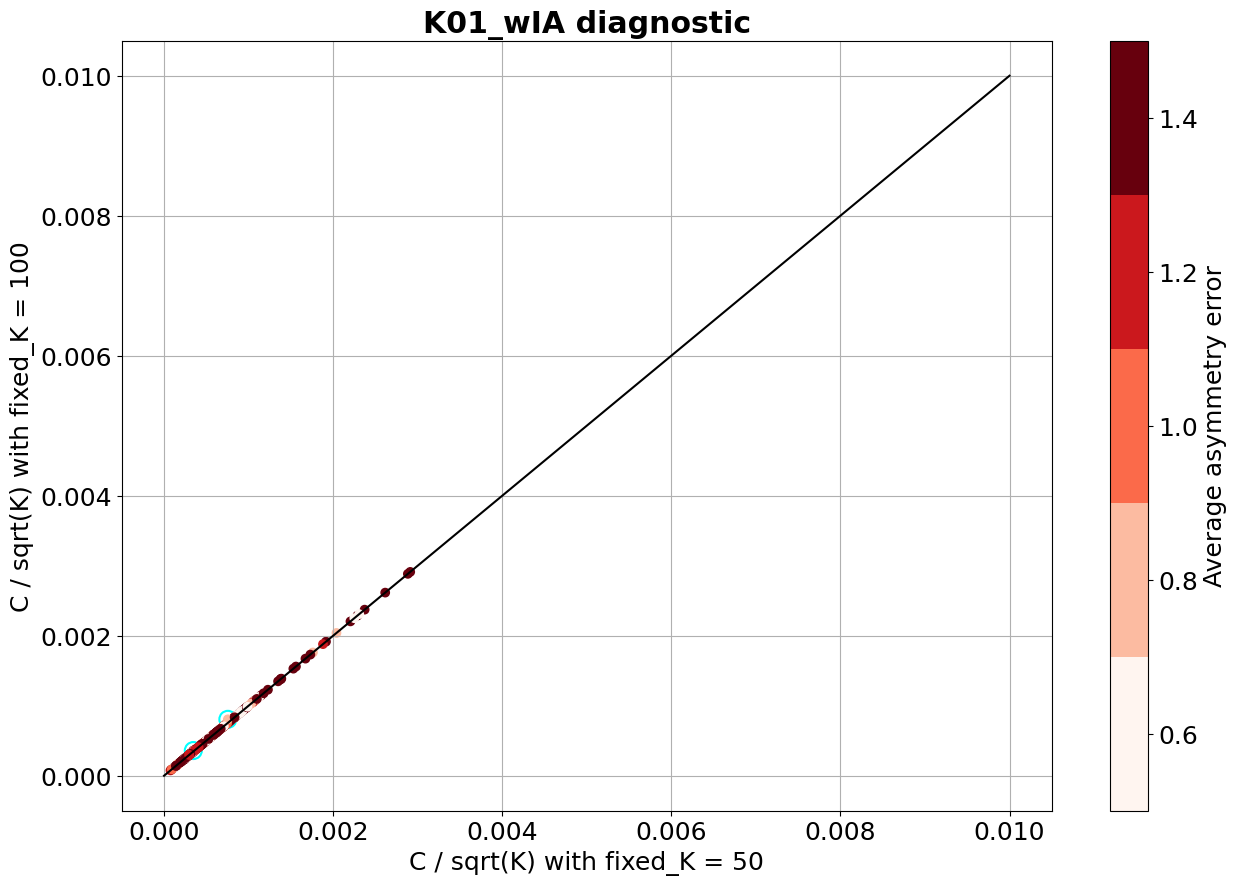

In [25]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_upper = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_upper).C_sqrtK_K01, dk01i_withKsetto100.where(msk_k01i_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto100.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

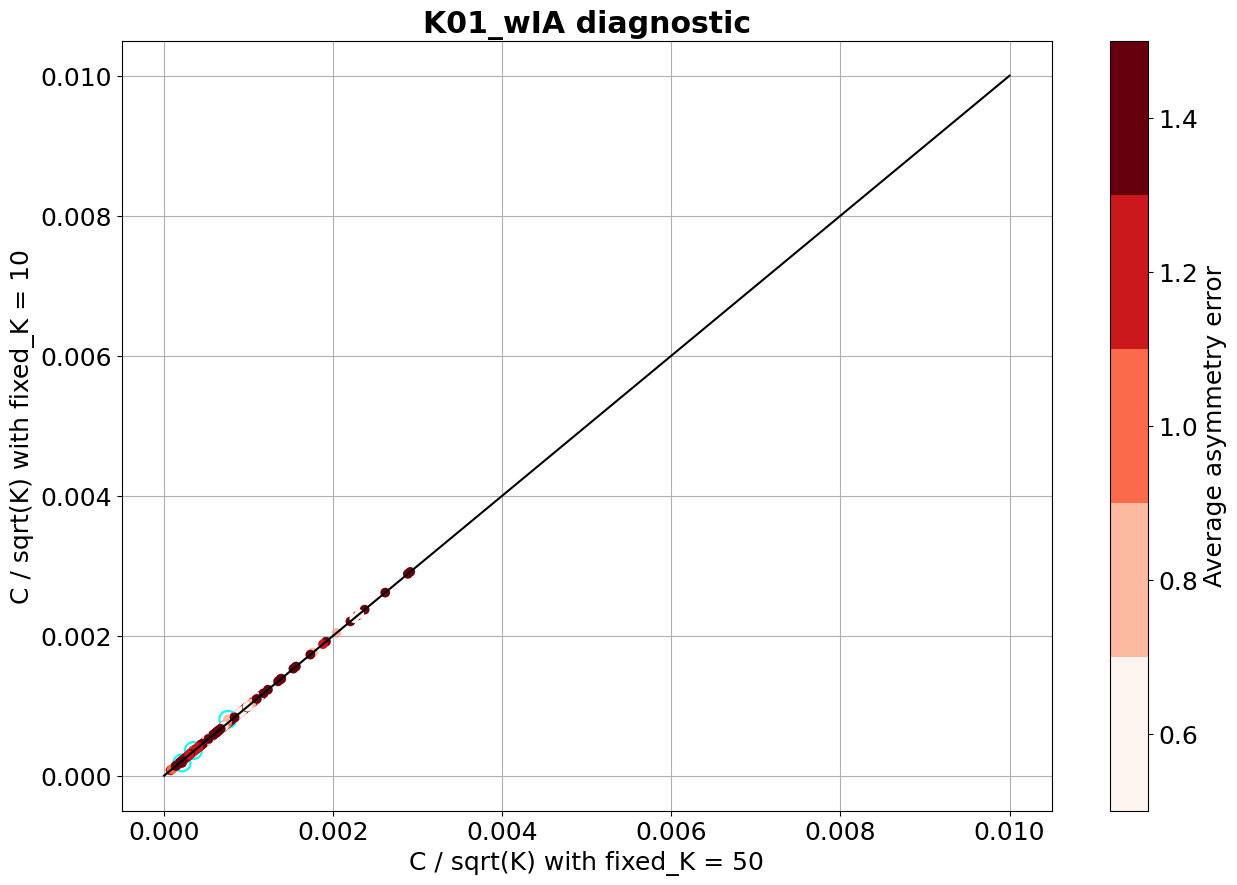

In [26]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_lower = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_lower).C_sqrtK_K01, dk01i_withKsetto10.where(msk_k01i_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto10.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 2 cases (see commented cell below).

In [27]:
# a  = dkg01i_withKsetto10.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)             & # Distance to coast
#     (dkg01i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto10.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto10.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01i_withKsetto100.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)            & # Distance to coast
#     (dkg01i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto100.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto100.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### e) K25_wIA

In [28]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto50.nc'
dkg25i = xr.open_dataset(p)
dk25i  = dkg25i.where(
    # (dkg25.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg25i.dist2coast  > dkg25i.r34)            & # Distance to coast
    (dkg25i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25i.vmx > 20)                            & # Test
    (dkg25i.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25i.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg25i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg25i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg25i.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25i.phase_avg_err <= 45)                 &           # Test
    # ((dkg25i.storm_speed_ibt / dkg25.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i.time))
print(len(dk25i.dropna(dim='time', subset=['vmx']).time))

354
263


In [29]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto100.nc'
dkg25i_withKsetto100 = xr.open_dataset(p)
dk25i_withKsetto100  = dkg25i_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)             & # Distance to coast
    (dkg25i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto100.vmx > 20)                                           & # Test
    (dkg25i_withKsetto100.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto100.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg25i_withKsetto100.storm_speed_ibt / dkg25_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto100.time))
print(len(dk25i_withKsetto100.dropna(dim='time', subset=['vmx']).time))

354
264


In [30]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto10.nc'
dkg25i_withKsetto10 = xr.open_dataset(p)
dk25i_withKsetto10  = dkg25i_withKsetto10.where(
    # (dkg25_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)              & # Distance to coast
    (dkg25i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto10.vmx > 20)                                           & # Test
    (dkg25i_withKsetto10.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto10.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25i_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto10.time))
print(len(dk25i_withKsetto10.dropna(dim='time', subset=['vmx']).time))

354
260


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

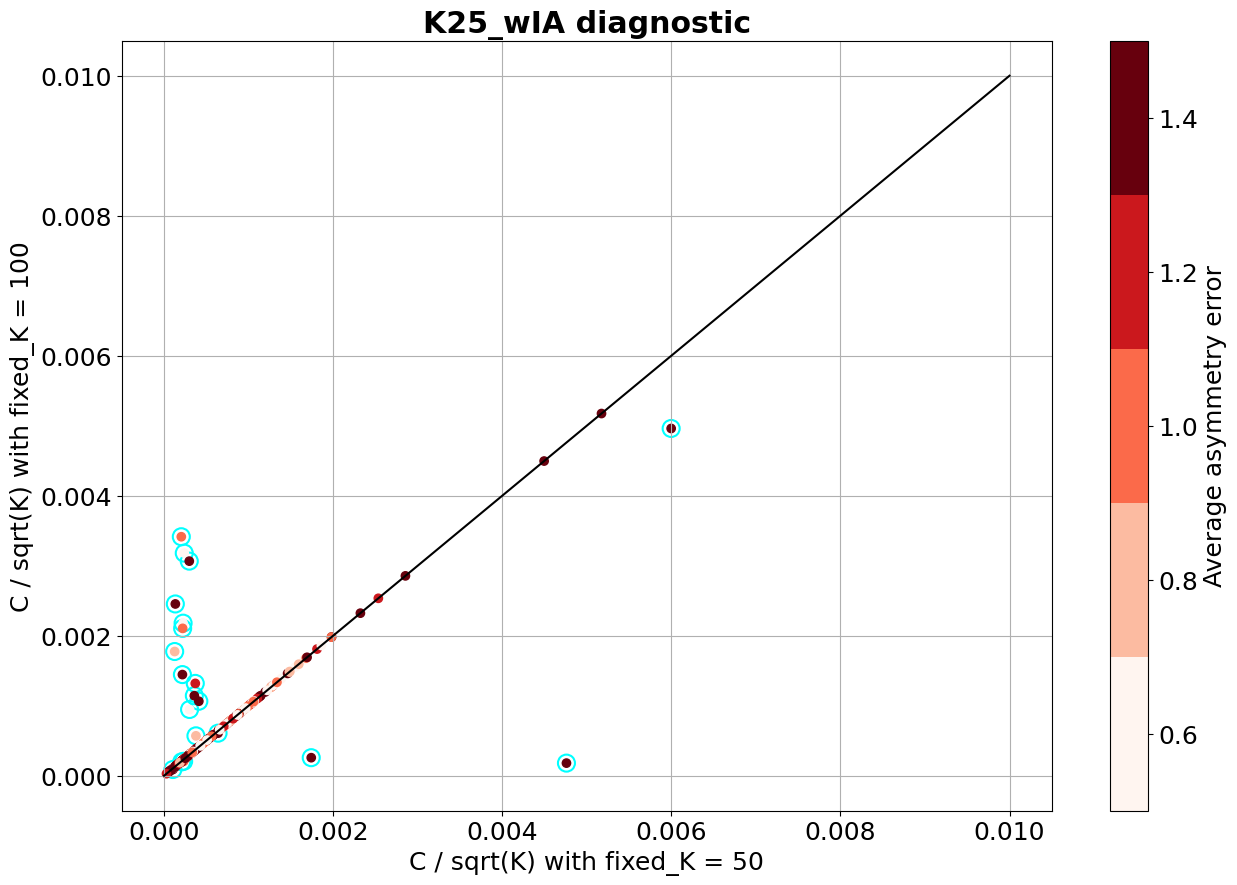

In [31]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_upper = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_upper).C_sqrtK_K25, dk25i_withKsetto100.where(msk_k25i_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto100.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

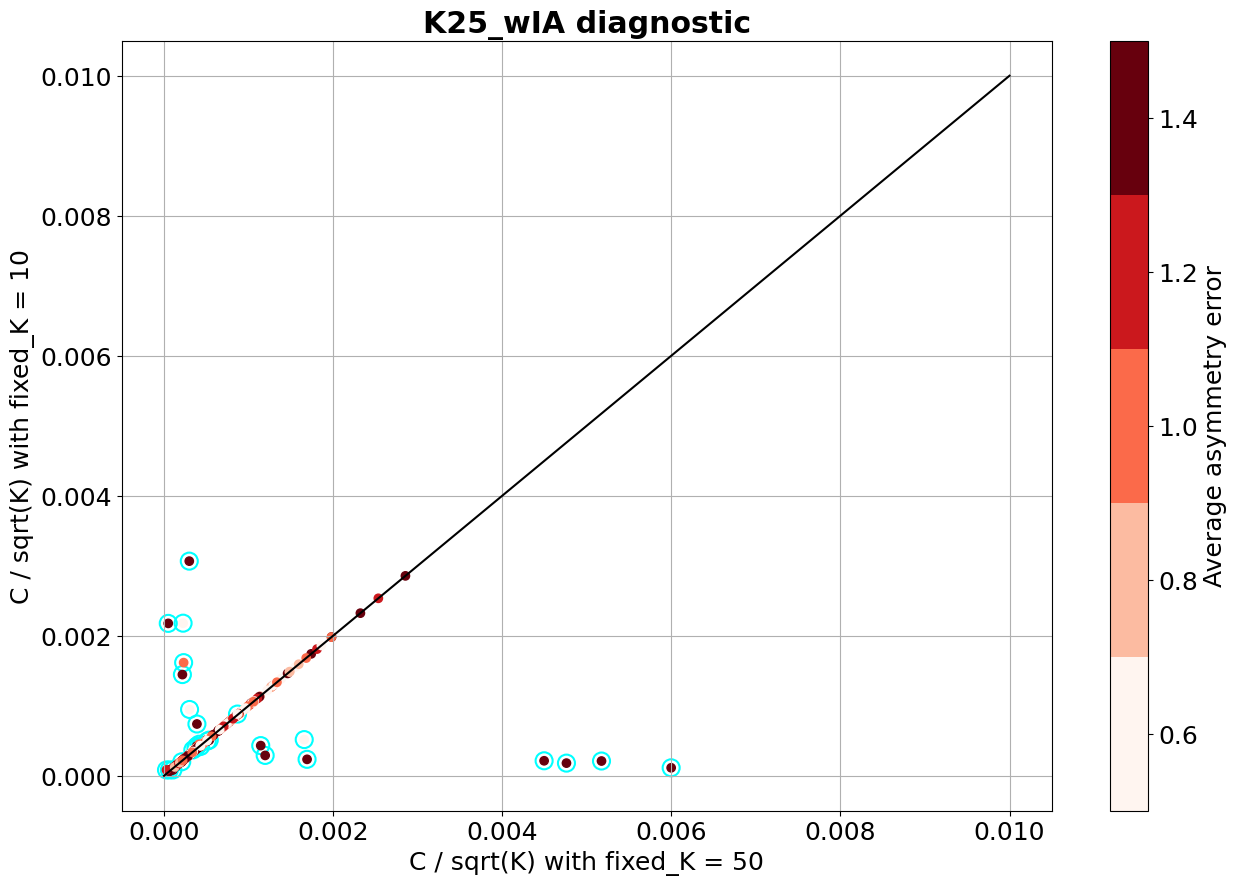

In [32]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_lower = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_lower).C_sqrtK_K25, dk25i_withKsetto10.where(msk_k25i_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto10.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 1 case (see commented cell below).

In [33]:
# a  = dkg25i_withKsetto10.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)             & # Distance to coast
#     (dkg25i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto10.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto10.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25i_withKsetto100.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)            & # Distance to coast
#     (dkg25i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto100.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto100.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### f) Clean the datasets

In [34]:
### FILTER BOTH DATASETS
# TO ENSURE THAT FIXED_K HAS NO IMPACT
dk01_clean  = dk01.where(~msk_k01_upper & ~msk_k01_lower)
dk25_clean  = dk25.where(~msk_k25_upper & ~msk_k25_lower)
dk01i_clean = dk01i.where(~msk_k01i_upper & ~msk_k01i_lower)
dk25i_clean = dk25i.where(~msk_k25i_upper & ~msk_k25i_lower)

# # TO DROP DUPLICATES FOR MULTIPLE SCAT COLLOCATIONS
# dk01i_clean = dk01i_clean.where(~dk01i_clean.indexes['time'].duplicated()).dropna(dim='time')
# dk25i_clean = dk25i_clean.where(~dk25i_clean.indexes['time'].duplicated()).dropna(dim='time')
dk01i_clean =  dk01i_clean.drop_duplicates(dim='time', keep='first')
dk25i_clean =  dk25i_clean.drop_duplicates(dim='time', keep='first')

### 1) Compute my own Cd and K values from all SAR data

In [35]:
### Hyperparameters
rs = np.linspace(1000, 5e5, 500)

In [36]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds  = dsg_filtered.isel(time=t)

    # Determined parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))
    Ut  = float(ds.speed)
    
    # Holland
    V    = holland_profile(rs, lat, B, vmn, rmx, vmx)

    # Get own Cd
    cd             = np.ones_like(V) * 1e-3 # Custom
    cd_lp          = np.ones_like(V) * 1e-3 # Large and Pond

    try:
        ### Custom
        # For r > R+
        cd[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        outer          = (V > 10.92) & (rs >= float(ds.rps))
        cd[outer]      = (0.49 + 0.065 * V[outer]) * 1e-3
        # For Rmax < r < R+
        cdps           = cd[rs >= float(ds.rps)][0]
        near           = (rs <= float(ds.rps)) & (rs >= float(ds.rmx))
        cd[near]       = cdps * rs[rs >= float(ds.rps)][0] * V[rs >= float(ds.rps)][0] ** 2 / (rs[near] * V[near] ** 2)

        # Average
        cd_mean1   = cd[(rs >= float(ds.rmx)) & (rs <= float(ds.r0))].mean()
        
        rmax_to_r0 = (rs >= float(ds.rmx)) & (rs <= float(ds.r0))
        # Radial integral
        cd_mean2   = np.trapz(cd[rmax_to_r0], rs[rmax_to_r0]) / float(ds.r0 - ds.rmx)
        # Cylindrical integral
        cd_mean3   = 2 * np.trapz(cd[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### Large and Pond formulation, averaged (cylindrical)
        # For V > 10.92 m/s
        cd_lp[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        low_ws            = (V > 10.92)
        cd_lp[low_ws]     = (0.49 + 0.065 * V[low_ws]) * 1e-3
        # For V > 38.62 m/s
        hgh_ws            = (V > 38.62)
        cd_lp[hgh_ws]     = 3 * 1e-3
        # Cylindrical average
        cd_mean_lp        = 2 * np.trapz(cd_lp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### K
        K_mean3           = 2 * np.trapz((V[rmax_to_r0] ** 2) * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### K - KPP formulation, averaged (cylindrical)
        # K_kpp      = (1 / 12) * 0.4 * 1000 * V * np.sqrt(cd_lp)                                  # Simpler form, Zhang and Drennan 2012  
        K_kpp      = (0.25 / 12) * 0.4 * 500  * V * np.sqrt(cd_lp) + 10 * 0.4 * V * np.sqrt(cd_lp) # h = 500m and H = 2km                         
        # K_kpp      = (0.5 / 12) * 0.4 * 1000 * V * np.sqrt(cd_lp) + 10 * 0.4 * V * np.sqrt(cd_lp) # h = 1km and H = 2km
        
        K_mean_kpp = 2 * np.trapezoid(K_kpp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        if PRMS['sav_fgs']:
            plt.plot(rs / 1000, cd * 1e3)
            plt.axvline(ds.rmx / 1000, c='k', linewidth=3)
            plt.axvline(ds.rps / 1000, c='k')
            plt.axvline(ds.r0  / 1000, c='k', linestyle='dashed')
            plt.xlim(0, 250)
            plt.xlabel(r'Distance from TC center (km)')
            plt.ylabel('Average Cd (x1e-3)')
            plt.grid()
    
            # Save
            plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()
        
    except IndexError:
        cd_mean1 = cd_mean2 = cd_mean3 = cd_mean_lp = K_mean_kpp = np.nan
    
    # Append
    ds['cd_mean1']   = cd_mean1
    ds['cd_mean2']   = cd_mean2
    ds['cd_mean3']   = cd_mean3
    ds['cd_mean_lp'] = cd_mean_lp
    ds['K_mean3']    = K_mean3
    ds['K_mean_kpp'] = K_mean_kpp
    listOfDatasets.append(ds)

# Concatenate
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
new_dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

  0%|          | 0/472 [00:00<?, ?it/s]

/tmp/ipykernel_14448/807933406.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean2   = np.trapz(cd[rmax_to_r0], rs[rmax_to_r0]) / float(ds.r0 - ds.rmx)
/tmp/ipykernel_14448/807933406.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean3   = 2 * np.trapz(cd[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)
/tmp/ipykernel_14448/807933406.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean_lp        = 2 * np.trapz(cd_lp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)
/tmp/ipykernel_14448/807933406.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


### 2) Assess relationship between (c1, c2), motion and shear

In [104]:
dsm25_fit = xr.merge([dk25_clean,   new_dsg], join="inner", compat='override')  # Fit (Clean)
dsm25_sFt = xr.merge([dk25_semiFit, new_dsg], join="inner", compat='override')  # SemiFit
dsm01_fit = xr.merge([dk01_clean,   new_dsg], join="inner", compat='override')  # Fit (Clean)
dsm25_wIA = xr.merge([dk25i_clean,   new_dsg], join="inner", compat='override') # wIA (Clean)
dsm01_wIA = xr.merge([dk01i_clean,   new_dsg], join="inner", compat='override') # wIA (Clean)

dsm25_fit['wght_cont']   = dsm25_fit.storm_speed_ibt * np.cos(np.deg2rad(dsm25_fit.storm_dir_ibt)) + dsm25_fit.vws_pmd * np.cos(np.deg2rad(dsm25_fit.wsd_pmd))
angles                   = (np.rad2deg(np.arctan2(dsm25_fit.c1_K25, dsm25_fit.c2_K25)) % 360).copy(deep=True) # Kepert 2025: "The effective coastline is rotated anticyclonically from the positive x-axis by an angle arctan2(c1/c2)
angles_bis               = (angles - 90) % 360 - 180                                                          # Adjust this angle so that it coincides with the def. in Fig. 2
dsm25_fit['angles_bis']  = angles_bis

dsm25_sFt['wght_cont']  = dsm25_sFt.storm_speed_ibt * np.cos(np.deg2rad(dsm25_sFt.storm_dir_ibt)) + dsm25_sFt.vws_pmd * np.cos(np.deg2rad(dsm25_sFt.wsd_pmd))
angles                  = (np.rad2deg(np.arctan2(dsm25_sFt.c1_K25, dsm25_sFt.c2_K25)) % 360).copy(deep=True)  # Kepert 2025: "The effective coastline is rotated anticyclonically from the positive x-axis by an angle arctan2(c1/c2)
angles_bis              = (angles - 90) % 360 - 180                                                           # Adjust this angle so that it coincides with the def. in Fig. 2
dsm25_sFt['angles_bis'] = angles_bis

dsm25_wIA['wght_cont']  = dsm25_wIA.storm_speed_ibt * np.cos(np.deg2rad(dsm25_wIA.storm_dir_ibt)) + dsm25_wIA.vws_pmd * np.cos(np.deg2rad(dsm25_wIA.wsd_pmd))
angles                  = (np.rad2deg(np.arctan2(dsm25_wIA.c1_K25, dsm25_wIA.c2_K25)) % 360).copy(deep=True)  # Kepert 2025: "The effective coastline is rotated anticyclonically from the positive x-axis by an angle arctan2(c1/c2)
angles_bis              = (angles - 90) % 360 - 180                                                           # Adjust this angle so that it coincides with the def. in Fig. 2
dsm25_wIA['angles_bis'] = angles_bis

# Remove SH
dsm25_fit_NH            = dsm25_fit.where(dsm25_fit.lat > 0)
dsm25_sFt_NH            = dsm25_sFt.where(dsm25_sFt.lat > 0)
dsm25_wIA_NH            = dsm25_sFt.where(dsm25_wIA.lat > 0)

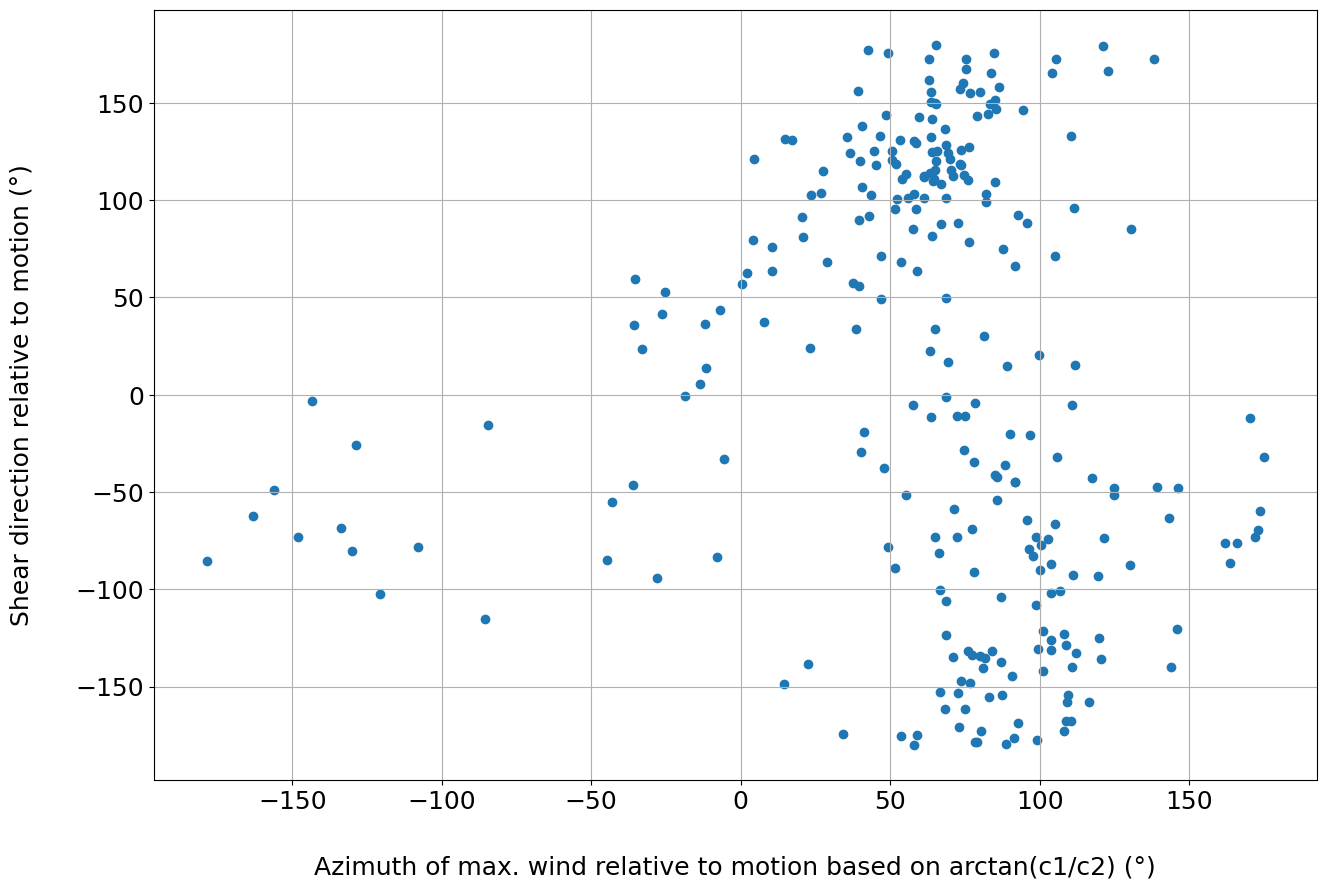

In [111]:
plt.scatter(dsm25_sFt.angles_bis, xr.where((dsm25_sFt_NH.wsd_pmd - dsm25_sFt_NH.storm_dir_ibt) % 360 < 180, (dsm25_sFt_NH.wsd_pmd - dsm25_sFt_NH.storm_dir_ibt) % 360, (dsm25_sFt_NH.wsd_pmd - dsm25_sFt_NH.storm_dir_ibt) % 360 - 360))
plt.xlabel('Azimuth of max. wind relative to motion based on arctan(c1/c2) (°)', labelpad=30)
plt.ylabel('Shear direction relative to motion (°)',      labelpad=30)
plt.grid()

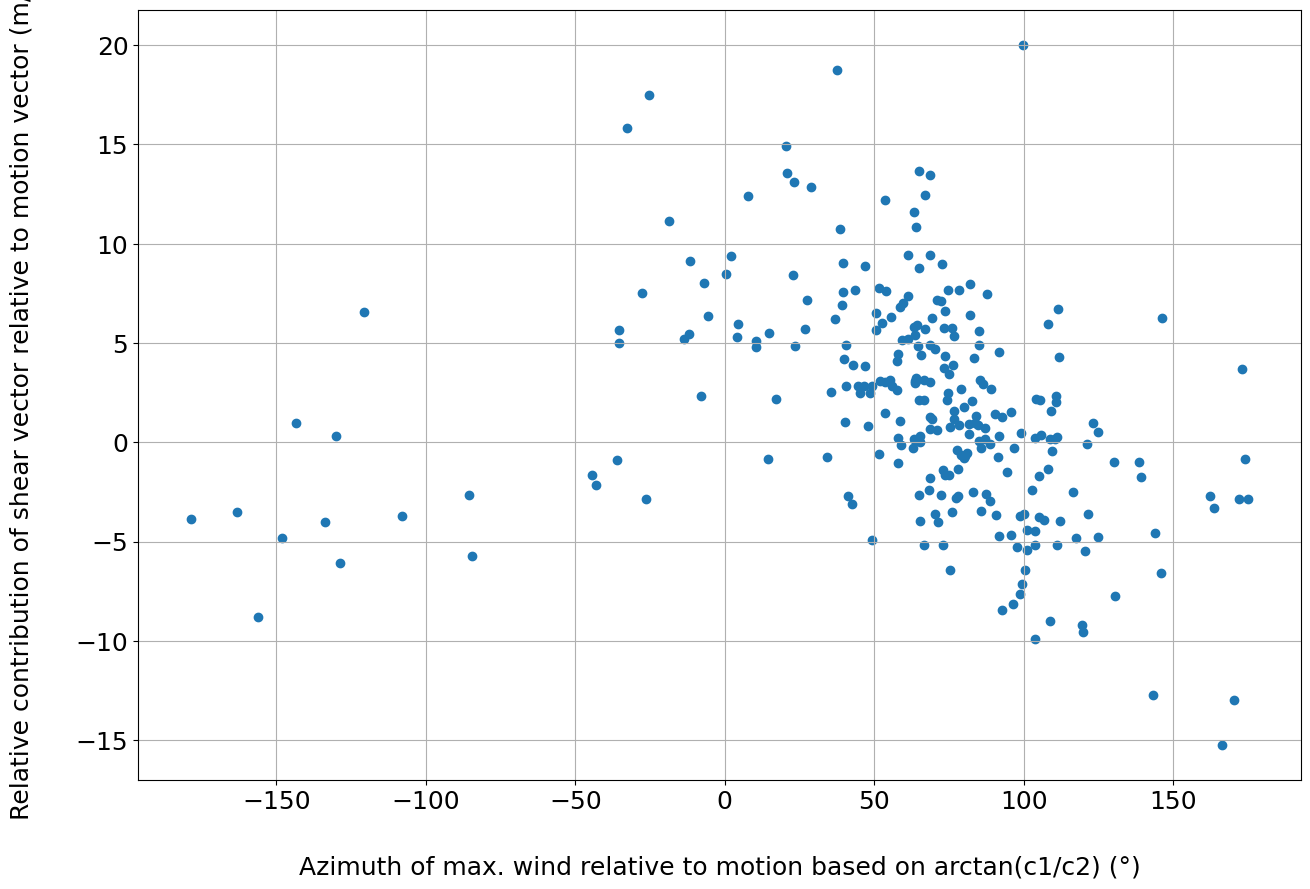

In [114]:
plt.scatter(dsm25_sFt.angles_bis, dsm25_sFt_NH.wght_cont)
plt.xlabel('Azimuth of max. wind relative to motion based on arctan(c1/c2) (°)',  labelpad=30)
plt.ylabel('Relative contribution of shear vector relative to motion vector (m/s)', labelpad=30)
plt.grid()

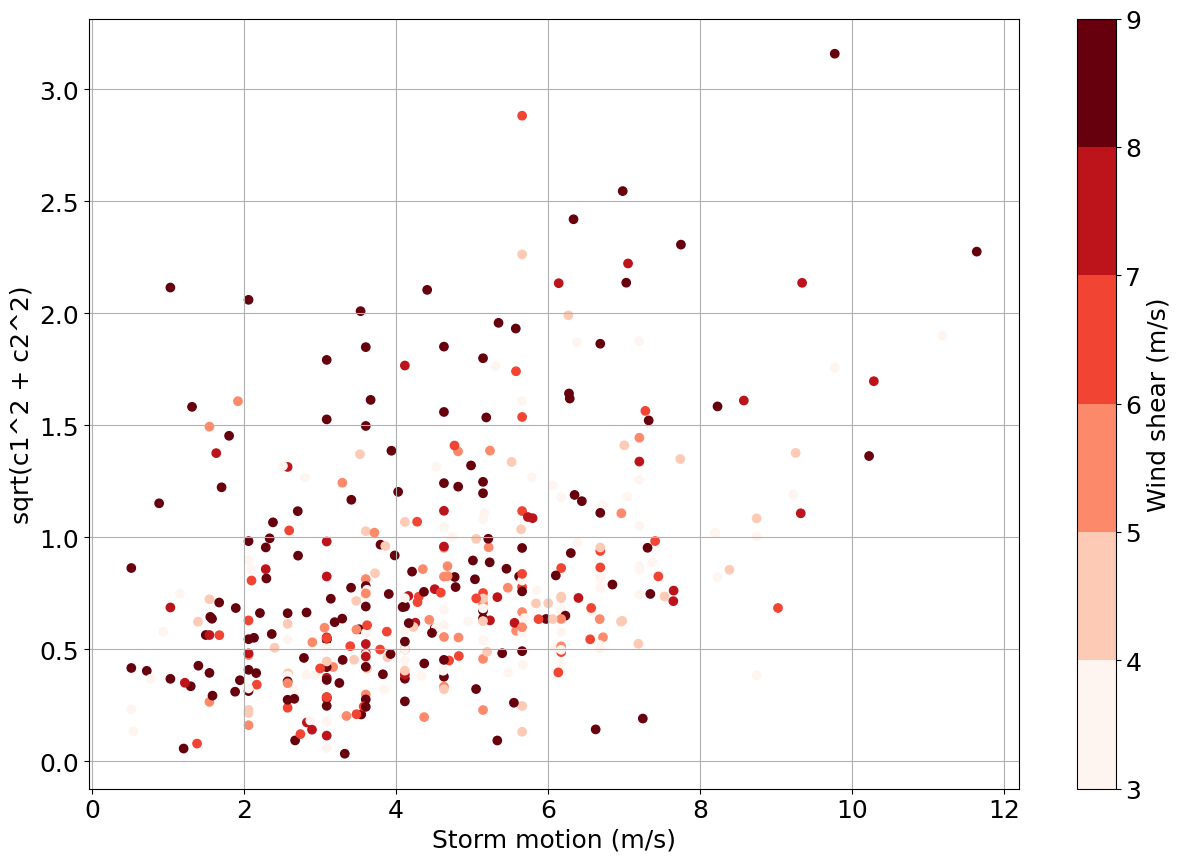

In [128]:
plt.scatter(dsm25_sFt.storm_speed_ibt, np.sqrt(dsm25_sFt.c1_K25 ** 2 + dsm25_sFt.c2_K25 ** 2), c=dsm25_sFt.vws_pmd, vmin=3, vmax=9, cmap=plt.get_cmap('Reds', 6))
plt.xlabel('Storm motion (m/s)')
plt.ylabel('sqrt(c1^2 + c2^2)')
plt.grid()
plt.colorbar(label='Wind shear (m/s)')